In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import skew
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

# Definitions
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline
njobs = 4
randomState = 0

In [2]:
# Get data
train = pd.read_csv("rawData/train.csv")
test = pd.read_csv("rawData/test.csv")
print("train : " + str(train.shape))
print("test : " + str(test.shape))

# Check for duplicates
idsUnique = len(set(train.Id))
idsTotal = train.shape[0]
idsDupli = idsTotal - idsUnique
print("There are " + str(idsDupli) + " duplicate IDs for " + str(idsTotal) + " total entries")

# Drop Id column
testIDs = test.Id
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

train : (1460, 81)
test : (1459, 80)
There are 0 duplicate IDs for 1460 total entries


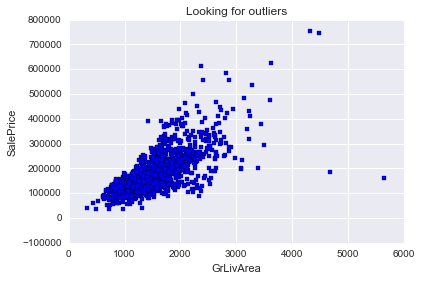

There seems to be 2 extreme outliers on the bottom right, really large houses that sold for really cheap
More generally, the author of the dataset recommends removing 'any houses with more than 4000 square feet' from the dataset (ref : https://ww2.amstat.org/publications/jse/v19n3/decock.pdf)


In [3]:
# Looking for outliers, as indicated in https://ww2.amstat.org/publications/jse/v19n3/decock.pdf
plt.scatter(train.GrLivArea, train.SalePrice, c = "blue", marker = "s")
plt.title("Looking for outliers")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

print("There seems to be 2 extreme outliers on the bottom right, really large houses that sold for really cheap")
print("More generally, the author of the dataset recommends removing 'any houses with more than 4000 square feet' \
from the dataset (ref : https://ww2.amstat.org/publications/jse/v19n3/decock.pdf)")
train = train[train.GrLivArea < 4000]

In [4]:
# Log transform the target for official scoring
# Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally
train.SalePrice = np.log1p(train.SalePrice)
y_train = train.SalePrice

In [5]:
# Handle missing values for features where median/mean or most common value doesn't make sense
alldata = pd.concat([train, test], axis = 0)

# Alley : data description says NA means "no alley access"
alldata.loc[:, "Alley"] = alldata.loc[:, "Alley"].fillna("None")
# BedroomAbvGr : NA most likely means 0
alldata.loc[:, "BedroomAbvGr"] = alldata.loc[:, "BedroomAbvGr"].fillna(0)
# BsmtQual etc : data description says NA for basement features is "no basement"
alldata.loc[:, "BsmtQual"] = alldata.loc[:, "BsmtQual"].fillna("No")
alldata.loc[:, "BsmtCond"] = alldata.loc[:, "BsmtCond"].fillna("No")
alldata.loc[:, "BsmtExposure"] = alldata.loc[:, "BsmtExposure"].fillna("No")
alldata.loc[:, "BsmtFinType1"] = alldata.loc[:, "BsmtFinType1"].fillna("No")
alldata.loc[:, "BsmtFinType2"] = alldata.loc[:, "BsmtFinType2"].fillna("No")
alldata.loc[:, "BsmtFullBath"] = alldata.loc[:, "BsmtFullBath"].fillna(0)
alldata.loc[:, "BsmtHalfBath"] = alldata.loc[:, "BsmtHalfBath"].fillna(0)
alldata.loc[:, "BsmtUnfSF"] = alldata.loc[:, "BsmtUnfSF"].fillna(0)
# CentralAir : NA most likely means No
alldata.loc[:, "CentralAir"] = alldata.loc[:, "CentralAir"].fillna("N")
# Condition : NA most likely means Normal
alldata.loc[:, "Condition1"] = alldata.loc[:, "Condition1"].fillna("Norm")
alldata.loc[:, "Condition2"] = alldata.loc[:, "Condition2"].fillna("Norm")
# EnclosedPorch : NA most likely means no enclosed porch
alldata.loc[:, "EnclosedPorch"] = alldata.loc[:, "EnclosedPorch"].fillna(0)
# External stuff : NA most likely means average
alldata.loc[:, "ExterCond"] = alldata.loc[:, "ExterCond"].fillna("TA")
alldata.loc[:, "ExterQual"] = alldata.loc[:, "ExterQual"].fillna("TA")
# Fence : data description says NA means "no fence"
alldata.loc[:, "Fence"] = alldata.loc[:, "Fence"].fillna("No")
# FireplaceQu : data description says NA means "no fireplace"
alldata.loc[:, "FireplaceQu"] = alldata.loc[:, "FireplaceQu"].fillna("No")
alldata.loc[:, "Fireplaces"] = alldata.loc[:, "Fireplaces"].fillna(0)
# Functional : data description says NA means typical
alldata.loc[:, "Functional"] = alldata.loc[:, "Functional"].fillna("Typ")
# GarageType etc : data description says NA for garage features is "no garage"
alldata.loc[:, "GarageType"] = alldata.loc[:, "GarageType"].fillna("No")
alldata.loc[:, "GarageFinish"] = alldata.loc[:, "GarageFinish"].fillna("No")
alldata.loc[:, "GarageQual"] = alldata.loc[:, "GarageQual"].fillna("No")
alldata.loc[:, "GarageCond"] = alldata.loc[:, "GarageCond"].fillna("No")
alldata.loc[:, "GarageArea"] = alldata.loc[:, "GarageArea"].fillna(0)
alldata.loc[:, "GarageCars"] = alldata.loc[:, "GarageCars"].fillna(0)
# HalfBath : NA most likely means no half baths above grade
alldata.loc[:, "HalfBath"] = alldata.loc[:, "HalfBath"].fillna(0)
# HeatingQC : NA most likely means typical
alldata.loc[:, "HeatingQC"] = alldata.loc[:, "HeatingQC"].fillna("TA")
# KitchenAbvGr : NA most likely means 0
alldata.loc[:, "KitchenAbvGr"] = alldata.loc[:, "KitchenAbvGr"].fillna(0)
# KitchenQual : NA most likely means typical
alldata.loc[:, "KitchenQual"] = alldata.loc[:, "KitchenQual"].fillna("TA")
# LotFrontage : NA most likely means no lot frontage
alldata.loc[:, "LotFrontage"] = alldata.loc[:, "LotFrontage"].fillna(0)
# LotShape : NA most likely means regular
alldata.loc[:, "LotShape"] = alldata.loc[:, "LotShape"].fillna("Reg")
# MasVnrType : NA most likely means no veneer
alldata.loc[:, "MasVnrType"] = alldata.loc[:, "MasVnrType"].fillna("None")
alldata.loc[:, "MasVnrArea"] = alldata.loc[:, "MasVnrArea"].fillna(0)
# MiscFeature : data description says NA means "no misc feature"
alldata.loc[:, "MiscFeature"] = alldata.loc[:, "MiscFeature"].fillna("No")
alldata.loc[:, "MiscVal"] = alldata.loc[:, "MiscVal"].fillna(0)
# OpenPorchSF : NA most likely means no open porch
alldata.loc[:, "OpenPorchSF"] = alldata.loc[:, "OpenPorchSF"].fillna(0)
# PavedDrive : NA most likely means not paved
alldata.loc[:, "PavedDrive"] = alldata.loc[:, "PavedDrive"].fillna("N")
# PoolQC : data description says NA means "no pool"
alldata.loc[:, "PoolQC"] = alldata.loc[:, "PoolQC"].fillna("No")
alldata.loc[:, "PoolArea"] = alldata.loc[:, "PoolArea"].fillna(0)
# SaleCondition : NA most likely means normal sale
alldata.loc[:, "SaleCondition"] = alldata.loc[:, "SaleCondition"].fillna("Normal")
# ScreenPorch : NA most likely means no screen porch
alldata.loc[:, "ScreenPorch"] = alldata.loc[:, "ScreenPorch"].fillna(0)
# TotRmsAbvGrd : NA most likely means 0
alldata.loc[:, "TotRmsAbvGrd"] = alldata.loc[:, "TotRmsAbvGrd"].fillna(0)
# Utilities : NA most likely means all public utilities
alldata.loc[:, "Utilities"] = alldata.loc[:, "Utilities"].fillna("AllPub")
# WoodDeckSF : NA most likely means no wood deck
alldata.loc[:, "WoodDeckSF"] = alldata.loc[:, "WoodDeckSF"].fillna(0)

In [6]:
# Some numerical features are actually really categories
alldata = alldata.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 50 : "SC50", 60 : "SC60",
                                           70 : "SC70", 75 : "SC75", 80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                           150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                           "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                       7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                          })

In [7]:
# Encode some categorical features as ordered numbers when there is information in the order
alldata = alldata.replace({"Alley" : {"Grvl" : 1, "Pave" : 2},
                           "BsmtCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                           "BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                           "BsmtFinType1" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, "ALQ" : 5, "GLQ" : 6},
                           "BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, "ALQ" : 5, "GLQ" : 6},
                           "BsmtQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                           "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                           "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                           "FireplaceQu" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                           "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, "Min2" : 6, 
                                           "Min1" : 7, "Typ" : 8},
                           "GarageCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                           "GarageQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                           "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                           "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                           "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                           "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                           "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                           "PoolQC" : {"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                           "Street" : {"Grvl" : 1, "Pave" : 2},
                           "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}}
                     )

In [8]:
# Create new features
# 1* Simplifications of existing features
alldata["SimplOverallQual"] = alldata.OverallQual.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                           4 : 2, 5 : 2, 6 : 2, # average
                                                           7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                          })
alldata["SimplOverallCond"] = alldata.OverallCond.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                           4 : 2, 5 : 2, 6 : 2, # average
                                                           7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                          })
alldata["SimplPoolQC"] = alldata.PoolQC.replace({1 : 1, 2 : 1, # average
                                                 3 : 2, 4 : 2 # good
                                                })
alldata["SimplGarageCond"] = alldata.GarageCond.replace({1 : 1, # bad
                                                         2 : 1, 3 : 1, # average
                                                         4 : 2, 5 : 2 # good
                                                        })
alldata["SimplGarageQual"] = alldata.GarageQual.replace({1 : 1, # bad
                                                         2 : 1, 3 : 1, # average
                                                         4 : 2, 5 : 2 # good
                                                        })
alldata["SimplFireplaceQu"] = alldata.FireplaceQu.replace({1 : 1, # bad
                                                           2 : 1, 3 : 1, # average
                                                           4 : 2, 5 : 2 # good
                                                          })
alldata["SimplFireplaceQu"] = alldata.FireplaceQu.replace({1 : 1, # bad
                                                           2 : 1, 3 : 1, # average
                                                           4 : 2, 5 : 2 # good
                                                          })
alldata["SimplFunctional"] = alldata.Functional.replace({1 : 1, 2 : 1, # bad
                                                         3 : 2, 4 : 2, # major
                                                         5 : 3, 6 : 3, 7 : 3, # minor
                                                         8 : 4 # typical
                                                        })
alldata["SimplKitchenQual"] = alldata.KitchenQual.replace({1 : 1, # bad
                                                           2 : 1, 3 : 1, # average
                                                           4 : 2, 5 : 2 # good
                                                          })
alldata["SimplHeatingQC"] = alldata.HeatingQC.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
alldata["SimplBsmtFinType1"] = alldata.BsmtFinType1.replace({1 : 1, # unfinished
                                                             2 : 1, 3 : 1, # rec room
                                                             4 : 2, 5 : 2, 6 : 2 # living quarters
                                                            })
alldata["SimplBsmtFinType2"] = alldata.BsmtFinType2.replace({1 : 1, # unfinished
                                                             2 : 1, 3 : 1, # rec room
                                                             4 : 2, 5 : 2, 6 : 2 # living quarters
                                                            })
alldata["SimplBsmtCond"] = alldata.BsmtCond.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                    })
alldata["SimplBsmtQual"] = alldata.BsmtQual.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                    })
alldata["SimplExterCond"] = alldata.ExterCond.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
alldata["SimplExterQual"] = alldata.ExterQual.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })

# 2* Combinations of existing features
# Overall quality of the house
alldata["OverallGrade"] = alldata["OverallQual"] * alldata["OverallCond"]
# Overall quality of the garage
alldata["GarageGrade"] = alldata["GarageQual"] * alldata["GarageCond"]
# Overall quality of the exterior
alldata["ExterGrade"] = alldata["ExterQual"] * alldata["ExterCond"]
# Overall kitchen score
alldata["KitchenScore"] = alldata["KitchenAbvGr"] * alldata["KitchenQual"]
# Overall fireplace score
alldata["FireplaceScore"] = alldata["Fireplaces"] * alldata["FireplaceQu"]
# Overall garage score
alldata["GarageScore"] = alldata["GarageArea"] * alldata["GarageQual"]
# Overall pool score
alldata["PoolScore"] = alldata["PoolArea"] * alldata["PoolQC"]
# Simplified overall quality of the house
alldata["SimplOverallGrade"] = alldata["SimplOverallQual"] * alldata["SimplOverallCond"]
# Simplified overall quality of the exterior
alldata["SimplExterGrade"] = alldata["SimplExterQual"] * alldata["SimplExterCond"]
# Simplified overall pool score
alldata["SimplPoolScore"] = alldata["PoolArea"] * alldata["SimplPoolQC"]
# Simplified overall garage score
alldata["SimplGarageScore"] = alldata["GarageArea"] * alldata["SimplGarageQual"]
# Simplified overall fireplace score
alldata["SimplFireplaceScore"] = alldata["Fireplaces"] * alldata["SimplFireplaceQu"]
# Simplified overall kitchen score
alldata["SimplKitchenScore"] = alldata["KitchenAbvGr"] * alldata["SimplKitchenQual"]
# Total number of bathrooms
alldata["TotalBath"] = alldata["BsmtFullBath"] + (0.5 * alldata["BsmtHalfBath"]) + alldata["FullBath"] + (0.5 * alldata["HalfBath"])
# Total SF for house (incl. basement)
alldata["AllSF"] = alldata["GrLivArea"] + alldata["TotalBsmtSF"]
# Total SF for 1st + 2nd floors
alldata["AllFlrsSF"] = alldata["1stFlrSF"] + alldata["2ndFlrSF"]
# Total SF for porch
alldata["AllPorchSF"] = alldata["OpenPorchSF"] + alldata["EnclosedPorch"] + alldata["3SsnPorch"] + alldata["ScreenPorch"]
# Has masonry veneer or not
alldata["HasMasVnr"] = alldata.MasVnrType.replace({"BrkCmn" : 1, "BrkFace" : 1, "CBlock" : 1, "Stone" : 1, "None" : 0})
# House completed before sale or not
alldata["BoughtOffPlan"] = alldata.SaleCondition.replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, 
                                                          "Family" : 0, "Normal" : 0, "Partial" : 1})

In [9]:
# Find most important features relative to target
print("Find most important features relative to target")
corr = alldata.corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice)

Find most important features relative to target
SalePrice            1.000
OverallQual          0.819
AllSF                0.817
AllFlrsSF            0.729
GrLivArea            0.719
SimplOverallQual     0.708
ExterQual            0.681
GarageCars           0.680
TotalBath            0.673
KitchenQual          0.667
GarageScore          0.657
GarageArea           0.655
TotalBsmtSF          0.642
SimplExterQual       0.636
SimplGarageScore     0.631
BsmtQual             0.615
1stFlrSF             0.614
SimplKitchenQual     0.610
OverallGrade         0.604
SimplBsmtQual        0.594
FullBath             0.591
YearBuilt            0.589
ExterGrade           0.587
YearRemodAdd         0.569
FireplaceQu          0.547
GarageYrBlt          0.544
TotRmsAbvGrd         0.533
SimplOverallGrade    0.527
SimplKitchenScore    0.523
FireplaceScore       0.518
                     ...  
SimplBsmtCond        0.204
BedroomAbvGr         0.204
AllPorchSF           0.199
LotFrontage          0.174
SimplFu

In [10]:
# Create new features
# 3* Polynomials on the top 25 existing features
alldata["OverallQual-s2"] = alldata["OverallQual"] ** 2
alldata["OverallQual-s3"] = alldata["OverallQual"] ** 3
alldata["OverallQual-Sq"] = np.sqrt(alldata["OverallQual"])
alldata["AllSF-2"] = alldata["AllSF"] ** 2
alldata["AllSF-3"] = alldata["AllSF"] ** 3
alldata["AllSF-Sq"] = np.sqrt(alldata["AllSF"])
alldata["AllFlrsSF-2"] = alldata["AllFlrsSF"] ** 2
alldata["AllFlrsSF-3"] = alldata["AllFlrsSF"] ** 3
alldata["AllFlrsSF-Sq"] = np.sqrt(alldata["AllFlrsSF"])
alldata["GrLivArea-2"] = alldata["GrLivArea"] ** 2
alldata["GrLivArea-3"] = alldata["GrLivArea"] ** 3
alldata["GrLivArea-Sq"] = np.sqrt(alldata["GrLivArea"])
alldata["SimplOverallQual-s2"] = alldata["SimplOverallQual"] ** 2
alldata["SimplOverallQual-s3"] = alldata["SimplOverallQual"] ** 3
alldata["SimplOverallQual-Sq"] = np.sqrt(alldata["SimplOverallQual"])
alldata["ExterQual-2"] = alldata["ExterQual"] ** 2
alldata["ExterQual-3"] = alldata["ExterQual"] ** 3
alldata["ExterQual-Sq"] = np.sqrt(alldata["ExterQual"])
alldata["GarageCars-2"] = alldata["GarageCars"] ** 2
alldata["GarageCars-3"] = alldata["GarageCars"] ** 3
alldata["GarageCars-Sq"] = np.sqrt(alldata["GarageCars"])
alldata["TotalBath-2"] = alldata["TotalBath"] ** 2
alldata["TotalBath-3"] = alldata["TotalBath"] ** 3
alldata["TotalBath-Sq"] = np.sqrt(alldata["TotalBath"])
alldata["KitchenQual-2"] = alldata["KitchenQual"] ** 2
alldata["KitchenQual-3"] = alldata["KitchenQual"] ** 3
alldata["KitchenQual-Sq"] = np.sqrt(alldata["KitchenQual"])
alldata["GarageScore-2"] = alldata["GarageScore"] ** 2
alldata["GarageScore-3"] = alldata["GarageScore"] ** 3
alldata["GarageScore-Sq"] = np.sqrt(alldata["GarageScore"])
alldata["GarageArea-2"] = alldata["GarageArea"] ** 2
alldata["GarageArea-3"] = alldata["GarageArea"] ** 3
alldata["GarageArea-Sq"] = np.sqrt(alldata["GarageArea"])
alldata["TotalBsmtSF-2"] = alldata["TotalBsmtSF"] ** 2
alldata["TotalBsmtSF-3"] = alldata["TotalBsmtSF"] ** 3
alldata["TotalBsmtSF-Sq"] = np.sqrt(alldata["TotalBsmtSF"])
alldata["SimplExterQual-2"] = alldata["SimplExterQual"] ** 2
alldata["SimplExterQual-3"] = alldata["SimplExterQual"] ** 3
alldata["SimplExterQual-Sq"] = np.sqrt(alldata["SimplExterQual"])
alldata["SimplGarageScore-2"] = alldata["SimplGarageScore"] ** 2
alldata["SimplGarageScore-3"] = alldata["SimplGarageScore"] ** 3
alldata["SimplGarageScore-Sq"] = np.sqrt(alldata["SimplGarageScore"])
alldata["BsmtQual-2"] = alldata["BsmtQual"] ** 2
alldata["BsmtQual-3"] = alldata["BsmtQual"] ** 3
alldata["BsmtQual-Sq"] = np.sqrt(alldata["BsmtQual"])
alldata["1stFlrSF-2"] = alldata["1stFlrSF"] ** 2
alldata["1stFlrSF-3"] = alldata["1stFlrSF"] ** 3
alldata["1stFlrSF-Sq"] = np.sqrt(alldata["1stFlrSF"])
alldata["SimplKitchenQual-2"] = alldata["SimplKitchenQual"] ** 2
alldata["SimplKitchenQual-3"] = alldata["SimplKitchenQual"] ** 3
alldata["SimplKitchenQual-Sq"] = np.sqrt(alldata["SimplKitchenQual"])
alldata["OverallGrade-2"] = alldata["OverallGrade"] ** 2
alldata["OverallGrade-3"] = alldata["OverallGrade"] ** 3
alldata["OverallGrade-Sq"] = np.sqrt(alldata["OverallGrade"])
alldata["SimplBsmtQual-2"] = alldata["SimplBsmtQual"] ** 2
alldata["SimplBsmtQual-3"] = alldata["SimplBsmtQual"] ** 3
alldata["SimplBsmtQual-Sq"] = np.sqrt(alldata["SimplBsmtQual"])
alldata["FullBath-2"] = alldata["FullBath"] ** 2
alldata["FullBath-3"] = alldata["FullBath"] ** 3
alldata["FullBath-Sq"] = np.sqrt(alldata["FullBath"])
alldata["YearBuilt-2"] = alldata["YearBuilt"] ** 2
alldata["YearBuilt-3"] = alldata["YearBuilt"] ** 3
alldata["YearBuilt-Sq"] = np.sqrt(alldata["YearBuilt"])
alldata["ExterGrade-2"] = alldata["ExterGrade"] ** 2
alldata["ExterGrade-3"] = alldata["ExterGrade"] ** 3
alldata["ExterGrade-Sq"] = np.sqrt(alldata["ExterGrade"])
alldata["YearRemodAdd-2"] = alldata["YearRemodAdd"] ** 2
alldata["YearRemodAdd-3"] = alldata["YearRemodAdd"] ** 3
alldata["YearRemodAdd-Sq"] = np.sqrt(alldata["YearRemodAdd"])
alldata["FireplaceQu-2"] = alldata["FireplaceQu"] ** 2
alldata["FireplaceQu-3"] = alldata["FireplaceQu"] ** 3
alldata["FireplaceQu-Sq"] = np.sqrt(alldata["FireplaceQu"])

In [11]:
# Create new features
# 4* Cross-products on the top 10 existing features
'''feats = ["OverallQual", "AllSF", "AllFlrsSF", "GrLivArea", "SimplOverallQual", "ExterQual", "GarageCars", "TotalBath", 
         "KitchenQual", "GarageScore", "GarageArea", "TotalBsmtSF", "SimplExterQual", "SimplGarageScore", "BsmtQual", 
         "1stFlrSF", "SimplKitchenQual", "OverallGrade", "SimplBsmtQual", "FullBath", "YearBuilt", "ExterGrade", 
         "YearRemodAdd", "FireplaceQu"]'''
alldata["OverallQual*AllSF"] = alldata["OverallQual"] * alldata["AllSF"]
alldata["OverallQual*AllFlrsSF"] = alldata["OverallQual"] * alldata["AllFlrsSF"]
alldata["OverallQual*GrLivArea"] = alldata["OverallQual"] * alldata["GrLivArea"]
alldata["OverallQual*SimplOverallQual"] = alldata["OverallQual"] * alldata["SimplOverallQual"]
alldata["OverallQual*ExterQual"] = alldata["OverallQual"] * alldata["ExterQual"]
alldata["OverallQual*GarageCars"] = alldata["OverallQual"] * alldata["GarageCars"]
alldata["OverallQual*TotalBath"] = alldata["OverallQual"] * alldata["TotalBath"]
alldata["OverallQual*KitchenQual"] = alldata["OverallQual"] * alldata["KitchenQual"]
alldata["OverallQual*GarageScore"] = alldata["OverallQual"] * alldata["GarageScore"]
alldata["AllSF*AllFlrsSF"] = alldata["AllSF"] * alldata["AllFlrsSF"]
alldata["AllSF*GrLivArea"] = alldata["AllSF"] * alldata["GrLivArea"]
alldata["AllSF*SimplOverallQual"] = alldata["AllSF"] * alldata["SimplOverallQual"]
alldata["AllSF*ExterQual"] = alldata["AllSF"] * alldata["ExterQual"]
alldata["AllSF*GarageCars"] = alldata["AllSF"] * alldata["GarageCars"]
alldata["AllSF*TotalBath"] = alldata["AllSF"] * alldata["TotalBath"]
alldata["AllSF*KitchenQual"] = alldata["AllSF"] * alldata["KitchenQual"]
alldata["AllSF*GarageScore"] = alldata["AllSF"] * alldata["GarageScore"]
alldata["AllFlrsSF*GrLivArea"] = alldata["AllFlrsSF"] * alldata["GrLivArea"]
alldata["AllFlrsSF*SimplOverallQual"] = alldata["AllFlrsSF"] * alldata["SimplOverallQual"]
alldata["AllFlrsSF*ExterQual"] = alldata["AllFlrsSF"] * alldata["ExterQual"]
alldata["AllFlrsSF*GarageCars"] = alldata["AllFlrsSF"] * alldata["GarageCars"]
alldata["AllFlrsSF*TotalBath"] = alldata["AllFlrsSF"] * alldata["TotalBath"]
alldata["AllFlrsSF*KitchenQual"] = alldata["AllFlrsSF"] * alldata["KitchenQual"]
alldata["AllFlrsSF*GarageScore"] = alldata["AllFlrsSF"] * alldata["GarageScore"]
alldata["GrLivArea*SimplOverallQual"] = alldata["GrLivArea"] * alldata["SimplOverallQual"]
alldata["GrLivArea*ExterQual"] = alldata["GrLivArea"] * alldata["ExterQual"]
alldata["GrLivArea*GarageCars"] = alldata["GrLivArea"] * alldata["GarageCars"]
alldata["GrLivArea*TotalBath"] = alldata["GrLivArea"] * alldata["TotalBath"]
alldata["GrLivArea*KitchenQual"] = alldata["GrLivArea"] * alldata["KitchenQual"]
alldata["GrLivArea*GarageScore"] = alldata["GrLivArea"] * alldata["GarageScore"]
alldata["SimplOverallQual*ExterQual"] = alldata["SimplOverallQual"] * alldata["ExterQual"]
alldata["SimplOverallQual*GarageCars"] = alldata["SimplOverallQual"] * alldata["GarageCars"]
alldata["SimplOverallQual*TotalBath"] = alldata["SimplOverallQual"] * alldata["TotalBath"]
alldata["SimplOverallQual*KitchenQual"] = alldata["SimplOverallQual"] * alldata["KitchenQual"]
alldata["SimplOverallQual*GarageScore"] = alldata["SimplOverallQual"] * alldata["GarageScore"]
alldata["ExterQual*GarageCars"] = alldata["ExterQual"] * alldata["GarageCars"]
alldata["ExterQual*TotalBath"] = alldata["ExterQual"] * alldata["TotalBath"]
alldata["ExterQual*KitchenQual"] = alldata["ExterQual"] * alldata["KitchenQual"]
alldata["ExterQual*GarageScore"] = alldata["ExterQual"] * alldata["GarageScore"]
alldata["GarageCars*TotalBath"] = alldata["GarageCars"] * alldata["TotalBath"]
alldata["GarageCars*KitchenQual"] = alldata["GarageCars"] * alldata["KitchenQual"]
alldata["GarageCars*GarageScore"] = alldata["GarageCars"] * alldata["GarageScore"]
alldata["TotalBath*KitchenQual"] = alldata["TotalBath"] * alldata["KitchenQual"]
alldata["TotalBath*GarageScore"] = alldata["TotalBath"] * alldata["GarageScore"]
alldata["KitchenQual*GarageScore"] = alldata["KitchenQual"] * alldata["GarageScore"]


In [12]:
# Differentiate numerical features (minus the target) and categorical features
categorical_features = alldata.select_dtypes(include = ["object"]).columns
numerical_features = alldata.select_dtypes(exclude = ["object"]).columns
numerical_features = numerical_features.drop("SalePrice")
print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))

X_train = alldata.iloc[:train.shape[0], :]
X_test = alldata.iloc[train.shape[0]: , :]

X_train_num = X_train[numerical_features]
X_train_cat = X_train[categorical_features]
X_test_num = X_test[numerical_features]
X_test_cat = X_test[categorical_features]

Numerical features : 204
Categorical features : 26


In [13]:
# Handle remaining missing values for numerical features by using median as replacement
print("NAs for numerical features in X_train : " + str(X_train_num.isnull().values.sum()))
X_train_num = X_train_num.fillna(X_train_num.median())
print("Remaining NAs for numerical features in X_train : " + str(X_train_num.isnull().values.sum()))

print("NAs for numerical features in X_test : " + str(X_test_num.isnull().values.sum()))
X_test_num = X_test_num.fillna(X_test_num.median())
print("Remaining NAs for numerical features in X_test : " + str(X_test_num.isnull().values.sum()))

NAs for numerical features in X_train : 81
Remaining NAs for numerical features in X_train : 0
NAs for numerical features in X_test : 97
Remaining NAs for numerical features in X_test : 0


In [14]:
# Log transform of the skewed numerical features to lessen impact of outliers
# Inspired by Alexandru Papiu's script : https://www.kaggle.com/apapiu/house-prices-advanced-regression-techniques/regularized-linear-models
# As a general rule of thumb, a skewness with an absolute value > 0.5 is considered at least moderately skewed
skewness = X_train_num.apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.5]
print(str(skewness.shape[0]) + " skewed numerical features to log transform in X_train")
skewed_features = skewness.index
X_train_num[skewed_features] = np.log1p(X_train_num[skewed_features])
X_test_num[skewed_features] = np.log1p(X_test_num[skewed_features])

157 skewed numerical features to log transform in X_train


In [15]:
# Create dummy features for categorical values via one-hot encoding
# Concatenate to make sure we get same number of dummy features in train and test
alldata_cat = pd.concat([X_train_cat, X_test_cat], axis = 0)

print("NAs for categorical features : " + str(alldata_cat.isnull().values.sum()))
alldata_cat = pd.get_dummies(alldata_cat)
print("Remaining NAs for categorical features : " + str(alldata_cat.isnull().values.sum()))

X_train_cat = alldata_cat.iloc[:train.shape[0], :]
X_test_cat = alldata_cat.iloc[train.shape[0]: , :]

NAs for categorical features : 8
Remaining NAs for categorical features : 0


In [16]:
# Join categorical and numerical features
X_train = pd.concat([X_train_num, X_train_cat], axis = 1)
X_test = pd.concat([X_test_num, X_test_cat], axis = 1)
print("New number of features in X_train : " + str(X_train.shape[1]))
print("New number of features in X_test : " + str(X_test.shape[1]))

New number of features in X_train : 407
New number of features in X_test : 407


In [17]:
# Standardize numerical features
stdSc = StandardScaler()
X_train.loc[:, numerical_features] = stdSc.fit_transform(X_train.loc[:, numerical_features])
X_test.loc[:, numerical_features] = stdSc.transform(X_test.loc[:, numerical_features])

In [18]:
# Write data in CSV files
X_train.to_csv("cleanData/X_train.csv", index = False)
X_test.to_csv("cleanData/X_test.csv", index = False)
y_train.to_csv("cleanData/y_train.csv", index = False)
testIDs.to_csv("cleanData/testIDs.csv", index = False)